# Anomaly detection using classification by type of machine

Nous allons essayer de détecter les sons anormaux pour une machine spécifique en appliquant la méthode suivante :

Entraîner un modèle de deepl learing Lenet avec le jeu de données d'entraînement afin d'avoir un modèle capable de classer le son par type de machine.

Utiliser le modèle pour prédire le type de machine d'un son et supposer que si le type détecté n'est pas le bon, il peut s'agir d'un son anormal.

## Import des librairies

In [1]:
# Mise en forme notebook (pleine largeur)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Python libraries:
# to handle datasets
import numpy as np # linear algebra
import random

# Initialization:
np.random.seed(1001)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import time

# for sound analysis
import librosa
import librosa.display
import IPython.display as ipd
from scipy import fftpack
from scipy import signal

from tqdm.notebook import tqdm

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# for image loading
from PIL import Image

# for Deep Learing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical
from sklearn import metrics, utils
import itertools

# for standardisation
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

#show pandas version
pd.__version__

'1.3.0'

## Chargement du dataset d'entrainement et de test

In [3]:
# Paths definition:
ROOT_AUDIO     = './../data' #Directory name where are all wave files
#ROOT_AUDIO     = '/content/drive/MyDrive/DCASE_DATASET/dev' #Directory name where are all wave files
DEV_DATA_PATH       = os.path.join(ROOT_AUDIO, 'dev_data')
EVAL_DATA_PATH      = os.path.join(ROOT_AUDIO, 'eval_data')

def load_sound_file(audio_path, duration=None):
    """
    Loads a sound file
    
    PARAMS
    ======
        audio_path (string) - location to the WAV file to open
    
    RETURNS
    =======
        signal (numpy array) - sound signal
        sampling_rate (float) - sampling rate detected in the file
    """
    multi_channel_data, sampling_rate = librosa.load(audio_path, sr=None, duration=duration)
    signal = np.array(multi_channel_data)
    
    return signal, sampling_rate

In [4]:
files = ROOT_AUDIO
data_location_csv = os.path.join(ROOT_AUDIO, 'dev_data.csv')

if os.path.exists(data_location_csv):
    print('CSV : Train data already exists, loading from file...')
    with open(data_location_csv, 'rb') as f:
        data_csv = pd.read_csv(f, dtype={"machine_id": "str", "sample_id": "str"});
    print('Done.')
        
else:
    data_csv = generate_dataset(files)
    print('Saving csv training data to disk...')
    data_csv.to_csv(data_location_csv)
#    with open(data_location_csv, 'wb') as f:
#        data_csv.to_csv(f, index=False);
    print('Done.')

CSV : Train data already exists, loading from file...
Done.


In [5]:
train_data = data_csv[data_csv['data_split'] == 'train'].reset_index(drop=True)
test_data = data_csv[data_csv['data_split'] == 'test'].reset_index(drop=True)
print(train_data.shape, test_data.shape)

(20119, 11) (10868, 11)


## Création du dataset d'entrainement et de test contenant les spectrogramme de MEL de chaque son

In [6]:
n_mels = 64 #128 #64; The number of Mels refers to the number Mel bands, or “bins”, that our Mel scale will be broken up into
n_fft = 2**13 #=2048 2**10 #2**11 #=2048;  2**13 #=8196; The n_fft length of the discrete Fourier transformation window describes the size of the window that will be used when performing each discrete Fourier transformation across the audio signal
hop_length = 2**11 #=512 n_fft // 2 # 2**9 #=512; describes how much this window is to be shifted along the audio signal during each step of STFT processing
#hop_length = 2**12 #=512 n_fft // 2 # 2**9 #=512; describes how much this window is to be shifted along the audio signal during each step of STFT processing
fmin = 20 #The minimum frequency describes the low frequency cutoff point that will be used when generating our Mel spectrograms.

In [7]:
# duration of audio file
duree_min = float(train_data['durations'].min())
duree_max = float(train_data['durations'].max())

In [8]:
def creat_mel_spectrograms(data_dir, duration=None, resizeaudio=True, n_fft=8192, hop_length=4096, n_mels=64):
    """
    Takes a list for WAV files as an input and generate a Mel spectrograms image
    
    PARAMS
    ======
        data_dir (string) - Root directory to audio files
        
    """
    
    for audioroot, _, audiofiles in os.walk(data_dir):
        # Parent Directory path
        print(audioroot)
        # Path Spectrogram image
        spectrogram_path = audioroot.replace(ROOT_AUDIO,'spectrogram')
        print(spectrogram_path)
        
        for index in tqdm(range(len(audiofiles)), desc='Extracting features'):
            filename = audiofiles[index]
            audiopath = os.path.join(audioroot, filename)
            file_ext = audiopath.split("\\")[-1].split("_")[-1].split(".")[-1]

            if file_ext == 'wav':
                # Create spectogram image from this audio signal:
                fig = plt.figure(figsize=[0.72,0.72])
                ax = fig.add_subplot(111)
                ax.axes.get_xaxis().set_visible(False)
                ax.axes.get_yaxis().set_visible(False)
                ax.set_frame_on(False)

                imagename = filename.replace('.wav','.jpg')
                image_path = os.path.join(spectrogram_path, imagename)
                
                # Create the directory
                os.makedirs(spectrogram_path, exist_ok = True)
                
                # Load audio file, sr = sample rate, signal = numpy array of audio file
                audio, sample_rate = load_sound_file(audiopath, duration=duration)
                
                #extract melspectrogram feature
                S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                
                #convert this melspectrogram feature into a log scaled melspectrogram
                librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max), hop_length=hop_length, cmap='viridis')

                #convert this melspectrogram feature into a log scaled melspectrogram
#                S = mel_features_extractor(audiopath, duration, resizeaudio=resizeaudio)
#                librosa.display.specshow(S)

                plt.savefig(image_path, dpi=100, bbox_inches='tight', pad_inches=0, format='jpg')
                plt.close('all')

In [9]:
def mel_features_extractor(file, duration=None , resizeaudio=False):
    """
    Compute a mel-scaled spectrogram and generate a vector from music dataset 
    
    PARAMS
    ======
        file (string) - location to the WAV file to open
        min_s (int) - fixed length in second to resize the audio file
        resizeaudio (boolean) - if True we truncate the audio file to min_ms time
        
    RETURNS
    =======
        mel_features (dataframe) - dataset
    """
    mel = []
    mel_features = []
    
    if resizeaudio:
        audio, sample_rate = load_sound_file(file, duration=duration)
    else:
        audio, sample_rate = load_sound_file(file)
        
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_features = librosa.power_to_db(mel**2, ref=np.max)

    return mel_features

In [10]:
train_data_shuffle = utils.shuffle(train_data)
test_data_shuffle = utils.shuffle(test_data)

Pour que les données soient traitables par le modèle Lenet, il faut encoder les type de machines

In [11]:
type_dict = {"fan" : 0, "pump" : 1, "slider" : 2, "ToyCar" : 3, "ToyConveyor" : 4, "valve" : 5}

def extract_mel_spectrograms(df):
    premier = True
    for row in tqdm(df.itertuples(),desc='MEL extraction',total=df.shape[0]):
        audiopath = row.pathname
        mel = mel_features_extractor(audiopath, duration=duree_min , resizeaudio=True)
        type_machine = type_dict[row.machine_type]
        if premier:
            X = np.array([mel])
            y = np.array(type_machine)
            premier = False
        else:
            X = np.append(X,[mel],axis=0)
            y = np.append(y,type_machine)
    return X, y

In [12]:
print('Train data processing')
X_train_spec, y_train_spec = extract_mel_spectrograms(train_data_shuffle)
print(X_train_spec.shape)
print(y_train_spec.shape)

print('Test data processing')
X_test_spec, y_test_spec = extract_mel_spectrograms(test_data_shuffle)

print(X_test_spec.shape)
print(y_test_spec.shape)

Train data processing


MEL extraction:   0%|          | 0/20119 [00:00<?, ?it/s]

(20119, 64, 79)
(20119,)
Test data processing


MEL extraction:   0%|          | 0/10868 [00:00<?, ?it/s]

(10868, 64, 79)
(10868,)


In [13]:
test_data_shuffle.head()

,pathname,filename,machine_id,sample_id,audio_format,machine_type,machine_kind,data_split,condition,durations,samplingrate
3831,./../data\dev_data\slider\test\normal_id_04_00...,normal_id_04_00000010.wav,04,00000010,wav,slider,real_machine,test,normal,10.0,16000
1064,./../data\dev_data\fan\test\anomaly_id_04_0000...,anomaly_id_04_00000298.wav,04,00000298,wav,fan,real_machine,test,anomaly,10.0,16000
8896,./../data\dev_data\ToyConveyor\test\normal_id_...,normal_id_02_00000506.wav,02,00000506,wav,ToyConveyor,real_machine,test,normal,10.0,16000
4194,./../data\dev_data\ToyCar\test\anomaly_id_01_0...,anomaly_id_01_00000173.wav,01,00000173,wav,ToyCar,real_machine,test,anomaly,11.0,16000
2666,./../data\dev_data\pump\test\normal_id_06_0000...,normal_id_06_00000035.wav,06,00000035,wav,pump,real_machine,test,normal,10.0,16000


## Standardisation des données avant traitement par le modèle Lenet

In [14]:
sc = StandardScaler()

X_train_spec_std = X_train_spec.reshape(-1,64*79)
X_train_spec_std = sc.fit_transform(X_train_spec_std)
X_train_spec_std = X_train_spec_std.reshape(-1,64,79)
X_train_spec_std = np.expand_dims(X_train_spec_std, -1)

X_test_spec_std = X_test_spec.reshape(-1,64*79)
X_test_spec_std = sc.transform(X_test_spec_std)
X_test_spec_std = X_test_spec_std.reshape(-1,64,79)
X_test_spec_std = np.expand_dims(X_test_spec_std, -1)

y_train_spec = to_categorical(y_train_spec)
y_test_spec = to_categorical(y_test_spec)

## Construction du modèle Lenet

In [15]:
# Architecture du modèle
inputs=Input(shape = (64, 79, 1), name = "Input")


conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (28, 28, 1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')

max_pool_2 = MaxPooling2D(pool_size = (2, 2))

flatten = Flatten()

dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 128,
                activation = 'relu')

dense_2 = Dense(units = 6,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)


x=dropout(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation

## Entrainement du modèle Lenet

In [16]:
training_history_lenet = lenet.fit(X_train_spec_std, y_train_spec,          # données
                                   validation_split = 0.2,              # split de test
                                   epochs = 20,                         # nombre d'epochs
                                   batch_size = 128)                   # taille des batchs

Epoch 1/20
126/126 [==============================] - 10s 81ms/step - loss: 0.4734 - accuracy: 0.8179 - val_loss: 0.2480 - val_accuracy: 0.9001
Epoch 2/20
126/126 [==============================] - 10s 80ms/step - loss: 0.1831 - accuracy: 0.9341 - val_loss: 0.1649 - val_accuracy: 0.9466
Epoch 3/20
126/126 [==============================] - 10s 80ms/step - loss: 0.1152 - accuracy: 0.9606 - val_loss: 0.1240 - val_accuracy: 0.9583
Epoch 4/20
126/126 [==============================] - 10s 80ms/step - loss: 0.0861 - accuracy: 0.9717 - val_loss: 0.0981 - val_accuracy: 0.9647
Epoch 5/20
126/126 [==============================] - 10s 80ms/step - loss: 0.0646 - accuracy: 0.9777 - val_loss: 0.1007 - val_accuracy: 0.9669
Epoch 6/20
126/126 [==============================] - 10s 80ms/step - loss: 0.0544 - accuracy: 0.9803 - val_loss: 0.0786 - val_accuracy: 0.9749
Epoch 7/20
126/126 [==============================] - 10s 80ms/step - loss: 0.0413 - accuracy: 0.9858 - val_loss: 0.1067 - val_accuracy:

On obtient une précision de 98%,  meilleure que celles obtenues avec les modèles de machine Learning

In [17]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

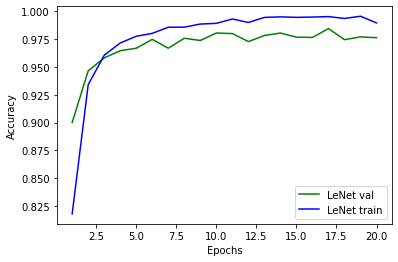

In [18]:
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe du score de test du réseau LeNet
plt.plot(np.arange(1 , 21, 1),
         val_acc_lenet, 
         label = 'LeNet val',
         color = 'green')

plt.plot(np.arange(1 , 21, 1),
         train_acc_lenet, 
         label = 'LeNet train',
         color = 'blue')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

## Prédiction avec le modèle RandomForest

In [19]:
test_pred_lenet = lenet.predict(X_test_spec_std)
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)
y_test_class = y_test_spec.argmax(axis = 1)

In [20]:
print(metrics.classification_report(y_test_class, test_pred_lenet_class))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1875
           1       0.68      0.76      0.72       856
           2       0.90      0.87      0.88      1290
           3       0.99      1.00      1.00      2459
           4       1.00      1.00      1.00      3509
           5       0.99      0.97      0.98       879

    accuracy                           0.94     10868
   macro avg       0.91      0.91      0.91     10868
weighted avg       0.94      0.94      0.94     10868



Les meilleurs résultats se vérifient avec ce rapport de classification

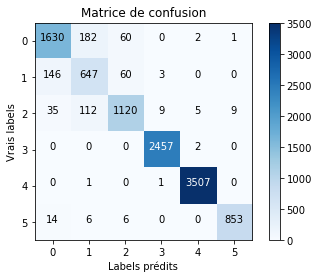

In [21]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_lenet_class)
classes = range(0,6)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

## Prédiction avec le modèle Lenet

On en profite pour remettre les types de machine en clair dans les données pour faciliter la lecture

In [22]:
result_lenet = pd.concat([test_data_shuffle, pd.Series(test_pred_lenet_class).rename('Predict_type')], axis=1)
transdict = {0: 'fan',
             1: 'pump',
             2: 'slider',
             3: 'ToyCar',
             4: 'ToyConveyor',
             5: 'valve'
}
result_lenet = result_lenet.replace({"Predict_type": transdict})

On construit une colonne contenant la prédiction de normalité fondée sur la règle suivante :

si la détection du type de machine est juste on suppose que le son est normal

si la détection est fausse on suppose que le son est anormal

In [23]:
result_lenet.loc[result_lenet['machine_type'] == result_lenet['Predict_type'], 'Predict_condition'] = 'normal'  
result_lenet.loc[result_lenet['machine_type'] != result_lenet['Predict_type'], 'Predict_condition'] = 'anomaly'
pd.crosstab(result_lenet.condition, result_lenet.Predict_condition, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,anomaly,normal
Classe réelle,,
anomaly,4454,1015
normal,4103,1296


In [24]:
pd.crosstab(index=[result_lenet.machine_type, result_lenet.condition], columns=result_lenet.Predict_condition)

Predict_condition       anomaly  normal
machine_type condition                 
ToyCar       anomaly        824     235
             normal        1084     316
ToyConveyor  anomaly        769     341
             normal        1603     796
fan          anomaly       1206     269
             normal         331      69
pump         anomaly        425      31
             normal         365      35
slider       anomaly        785     105
             normal         359      41
valve        anomaly        445      34
             normal         361      39

Les résultats de prédiction d'anomalies sont biens meilleures qu'avec les modèles de marchine learning

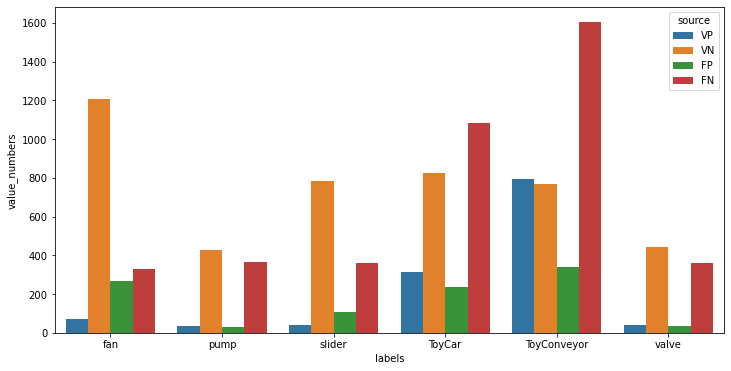

In [25]:
colonne = result_lenet.machine_type.unique().tolist()

dict_analyse = {}
VP, VN, FP, FN = [], [], [], []
for col in colonne:
    VP.append (result_lenet [(result_lenet['condition'] == "normal" ) & (result_lenet['Predict_condition'] == "normal") & (result_lenet['machine_type'] == col) ].shape[0])
    VN.append (result_lenet [(result_lenet['condition'] == "anomaly" ) & (result_lenet['Predict_condition'] == "anomaly") & (result_lenet['machine_type'] == col) ].shape[0])
    FP.append (result_lenet [(result_lenet['condition'] == "anomaly" ) & (result_lenet['Predict_condition'] == "normal") & (result_lenet['machine_type'] == col) ].shape[0])
    FN.append (result_lenet [(result_lenet['condition'] == "normal" ) & (result_lenet['Predict_condition'] == "anomaly") & (result_lenet['machine_type'] == col) ].shape[0])
    
dict_analyse ['labels'] = colonne
dict_analyse ['VP'] = VP
dict_analyse ['VN'] = VN
dict_analyse ['FP'] = FP
dict_analyse ['FN'] = FN

analyse = pd.DataFrame(dict_analyse)

columns = ["labels", "VP", "VN", "FP", "FN"]
analyse_melted = pd.melt(analyse, id_vars=columns[0], var_name="source", value_name="value_numbers")
fig = plt.figure(figsize=(12.0, 6.0))
g = sns.barplot(x=columns[0], y="value_numbers", hue="source", data=analyse_melted)
plt.show()